### Objectives
* Build a decision tree classifier using sklearn
* Analyze and improve decision tree classifier iteratively
* Apply best practices to decision trees

### What is a Gini Index and What is Entropy?
* Entropy - Checking for how messy data is...looking at how many different classifiers are in a population of data.
* Entropy - Measure of disorder
* High Entropy -> Low Information Gain
* High Entropy -> Low Separability
* Gini Index - Measurement of the purity of a split
    * Gini Index Low -> High Purity

* What is typically picked for the Root Node of a Decision Tree
    * 'Best Predictor' - Whatever feature is most important ~ feature with the highest purity (information gain)
* After that your splits should have higher purity as the tree goes down.

### Outline
* Discuss Gini Index/Entropy
* Build a Decision Tree
* Visualize It

In [1]:
import pandas as pd
import numpy as np

import scipy

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_df_load_set(load_set):
    dataset = load_set()
    data = dataset.data
    columns = dataset.feature_names
    target = dataset.target
    df = pd.DataFrame(data, columns=columns)
    df['target'] = target
    return df

In [3]:
df = create_df_load_set(load_iris)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
df.target.unique()

array([0, 1, 2])

### Let's discuss multicollinearity of decision trees

In [5]:
df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


### What do we notice about the correlation matrix?
- petalwidth has highest correlation with target
- we have multicollinearity with petal length and petal width
- sepal length and petal length and petal width


### Is that a problem?
- In Linear Regression this is a problem
- In Logistic Regression this is also a problem

- Mathematically, multicollinearity isn't an issue for non parametric methods. 
- Determine that your data is conditioned

In [6]:
x, y = df.drop(['target'], axis=1), df.target

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.80)

### Let's build a decision tree

In [8]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=10, min_samples_leaf=8)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [9]:
clf.score(xtrain, ytrain)

0.9666666666666667

In [10]:
clf.score(xtest, ytest) # train score = 100% -> overfitting on training data




0.9333333333333333

### Let's visualize our tree
[Source is Medium Article](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


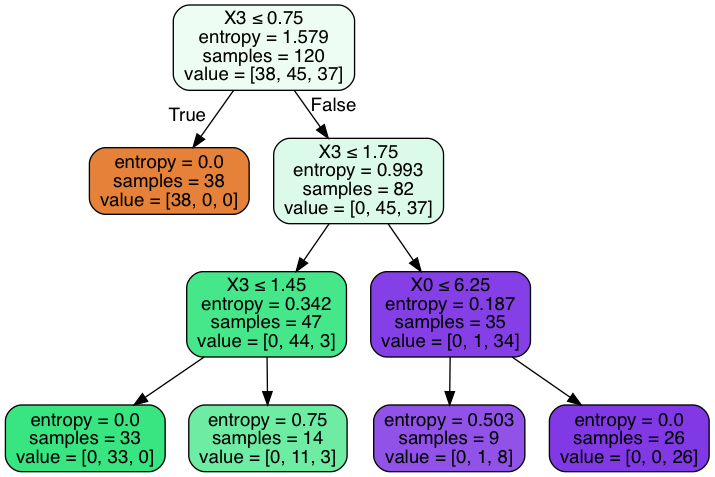

In [12]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### If you're increasing robustness but test score stays stagnant, what does this indicate?

### We tuned some hyperparameters, now let's look at attributes

In [14]:
feature_importance_vals = clf.feature_importances_
features = x.columns

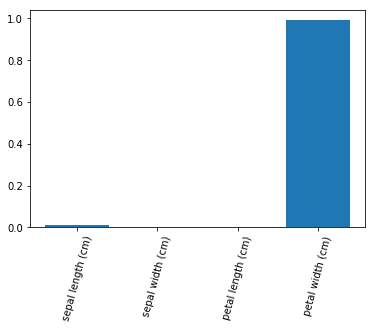

In [15]:
plt.bar(features, feature_importance_vals)
plt.xticks(features, features, rotation=75)
plt.show()

In [20]:
scipy.sparse.csr_matrix.todense(clf.decision_path(xtest)) # SHOWS THE NODES THAT INTERACT WITH EACH X VALUE AS 1

matrix([[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1,

In [16]:
xtest.shape

(30, 4)

In [17]:
xtest.iloc[0]

sepal length (cm)    6.0
sepal width (cm)     2.2
petal length (cm)    5.0
petal width (cm)     1.5
Name: 119, dtype: float64

In [18]:
clf.predict(xtest.iloc[0].values.reshape(1, -1))

array([1])

### Assessment
* Learned about overfitting decision trees - prone to overfitting
* Tuning hyperparameters
* Pruning the tree can prevent overfitting
    * Prune by limiting depth or limiting splits size requirements
* Assessing and taking actions from feature importances